In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.gridspec as gridspec

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

plt.ion()

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

author = "analyst@hammerdirt"

# set the fail rate to test
a_fail_rate = 50

# name of the output folder:
name_of_project = 'bassin_report_linth'

# set the maps
bassin_map = PILImage.open("resources/maps/linth_scaled.jpeg")
land_use_map = PILImage.open("resources/maps/land_use_linth.jpeg")

# the search term for the river bassin
bassin_name = 'linth'

# use water_name_slug
lakes_of_interest = ['zurichsee', 'walensee']
lake_colors=["darkblue", 'aquamarine']

# the names for the survey area and the cumulative data
level_names = ["Linth survey area","All survey areas"]

# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 50
unit_label = 'p/50m'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# colors for gradients
colors = ['beige', 'navajowhite', 'sandybrown', 'salmon', 'sienna']
nodes = [0.0, 0.2, 0.6, 0.8, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

# Linth survey area

<!-- 
<a id='toc'></a>
#### Contents

[Scope: description of survey area](#scope)
  * survey locations
  * lakes and rivers
  * municipalities and effected population
   
[Survey dimensions: locations, aggregated totals](#aggregatedtotals)
  * weights and measures: cumulative
  * weights and measures: cumulative by water feature
  * survey totals by location: pcs/m by date
  * Empirical cumulative distribution of survey results: lakes
  * material type: % of total
   
[Trash removed: the most common objects](#combinedtopten)
  * the most common objects definition
  * the most abundant objects
  * objects found in at least half the surveys
  * [the most common objects](#themostcommonobjects)
    * median pcs/m
    * fail rates
    * monthly results
    * association with land use attributes

[Trash removed: rivers](#rivers)
  * survey totals
  * most common objects

[Annex](#annex)
  * detail of fragmented plastics and foams
  * surveyors  
  * survey location coordinates
  * itemized list of objects removed -->

<!-- <a id="scope"></a>

### Scope -->
<!-- 
The Aare source is the Aare Glaciers in the Bernese Alps of south-central Switzerland. The Aare is the longest river entirely within Switzerland with a length of 295 km and drainage area of 17,779 km2. Following the Aare Gorge, the river expands into the glacial Lake Brienz. The Aare is canalized at Interlaken before entering Lake Thun and exiting through the city of Thun. The river then flows northwest surrounding the old city center of Bern on three sides. Continuing west to Lake Wohlen Reservoir it turns north to Aarberg and is diverted west into Lake Biel by the Hagneck Canal, one of a series of major water corrections made in the 19th and 20th centuries connecting Neuchatel, Biel and Morat lakes through canalization. From the upper end of Lake Biel, at Nidau, the river exits through the Nidau-Büren Canal/Aare Canal.

The Limmat and Reuss rivers, two major tributaries converge into the Aare at the Limmatspitz between the cities of Brugg and Untersiggenthal in Canton Aargau. The Aare river ends in the north-western region of Koblenz, Switzerland where it joins the Rhine river which eventually terminates in the North Sea. -->


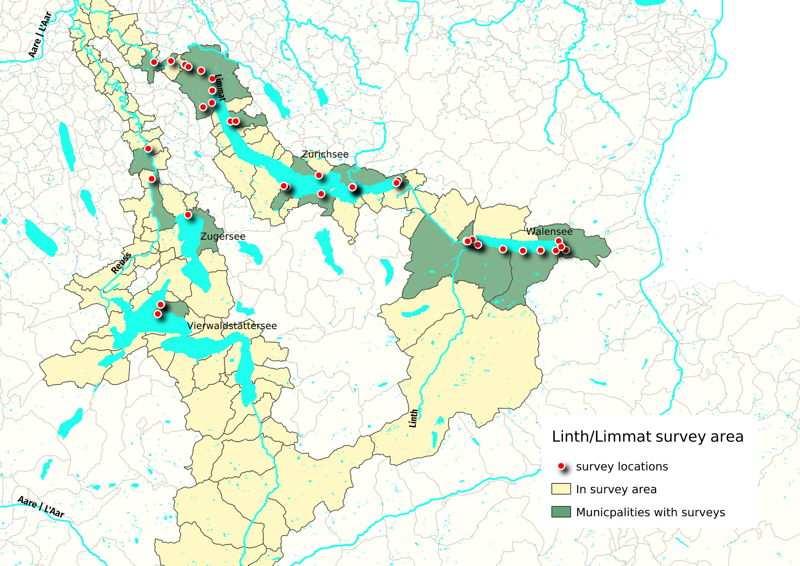

In [2]:
output = io.BytesIO()
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [3]:
# define the final survey data set here:
a_data = survey_data.copy()

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start- end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# make a loc_date column from the survey data
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# combine lugano and maggiore
# if the river bassin name does not equal tresa leave it, else change it to ticino
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# combine reuss and linth
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'reuss', 'linth' )

# assign the reporting value
a_data[unit_label] = (a_data.pcs_m * reporting_unit).round(2)

# scale the streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# save the data before aggregating to test
before_agg = a_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

# this extracts and aggregates the members of the two code groups, returns a dataframe
the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
a_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# the daily survey totals of all the data for the survey period
a_dt = a_data.groupby(['loc_date', 'date','water_name_slug'], as_index=False).agg(agg_pcs_quantity)

# define the feature data
fd = a_data.loc[a_data.river_bassin == bassin_name].copy()

# the totals for each survey and the locations in the feature data
fd_dt=fd.groupby(['loc_date', 'date','water_name_slug'], as_index=False).agg(agg_pcs_quantity)

# the unique locations and samples
fd_locs = fd.location.unique()
fd_samps = fd.loc_date.unique()

# gather the dimensional data for the time frame from dfDims
# match records to survey data
fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# key the quantity from the survey totals to the dimensional data
try_this = {(x[0],dt.datetime.strftime(x[1].to_pydatetime(), "%Y-%m-%d")):fd_dt[fd_dt.loc_date == x]['quantity'].to_numpy()[0] for x in fd_dt.loc_date.unique()}

# map quantity per survey to the dims data
fd_dims['quantity'] = fd_dims.loc_date.map(lambda x: ut.use_this_key(x, try_this))

# map the survey area name to the dims data record
m_ap_to_survey_area = fd[['location', 'river_bassin']].drop_duplicates().to_dict(orient='records')
a_new_map = {x['location']:x['river_bassin'] for x in m_ap_to_survey_area}

# make a survey area column in the dims data
fd_dims['survey area'] = fd_dims.location.map(lambda x: ut.use_this_key(x, a_new_map))

# keep the dims that did not get tagged with a qty
no_qty = fd_dims[fd_dims.quantity == 'bad key']

# drop the dims that did not match
som_dims = fd_dims[fd_dims.quantity != 'bad key'].copy()
som_dims['water_name_slug'] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# identify the surveys with no matching dimensional data
no_matching_dim_records = [x for x in list(fd_samps) if x not in list(fd_dims.loc_date.unique())]

# survey totals
dt_all = a_data.groupby(['loc_date','location','river_bassin', 'water_name_slug','date'], as_index=False).agg(agg_pcs_quantity)

# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][['city','population']].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index('city', drop=True, inplace=True)

# code totals for the river bassin
fd_code_t= fd.groupby(['code', 'groupname'], as_index=False).agg({'quantity':'sum', 'fail':'sum', 'p/50m':'median'})
fd_code_t.rename(columns={"groupname":'utility'}, inplace=True)
fd_code_t["% of total"] = fd_code_t.quantity/fd_code_t.quantity.sum()
fd_code_t.set_index('code', inplace=True)
fd_code_t.sort_values(by='quantity', ascending=False, inplace=True)
fd_code_t['material'] = fd_code_t.index.map(lambda x: code_material_map[x])
fd_code_t['item'] = fd_code_t.index.map(lambda x: code_description_map.loc[x])
fd_code_t["% of total"] = (fd_code_t["% of total"]*100).round(1)
fd_code_t["fail rate"] = ((fd_code_t["fail"]/len(fd.loc_date.unique()))*100).round(1)

# objects with a fail rate of > 50% in the survey area
most_common = fd_code_t[fd_code_t["fail rate"] > 50].sort_values(by='quantity', ascending=False)

# material totals:
fd_mat_t = fd_code_t[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# map total quantity per feature:
qty_all_features = fd.groupby('water_name_slug').quantity.sum()
qty_feature = {wname_wname.loc[x][0]:qty_all_features[x] for x in qty_all_features.index}

# summary statistics:
fd_n_samps = len(fd_samps)
fd_n_obj = fd.quantity.sum()
fd_n_locs = len(fd_locs)
fd_n_munis = len(fd_pop_map.index)
fd_effected_population = fd_pop_map.sum()

lakes = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name'].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'r')]['water_name'].unique()

obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results."
munis_joined = ', '.join(sorted(fd_pop_map.index))
lakes_joined = ', '.join(sorted(lakes))
rivers_joined = ', '.join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context } {admin_context}

*The lakes in this report:*\n\n{lakes_joined}

*The rivers in this report:*\n\n{rivers_joined}

*The municipalities in this report:*\n\n{munis_joined}
"""

# this will produce a points layer on QGIS with the median units and the total quantity:
# if needed make a map of the medain survey result for each location
# lat_lon_map = dfBeaches[['latitude', 'longitude']]
# median_survey_result_all_locations = dt_all.groupby(['location', 'river_bassin','water_name_slug'], as_index=False).agg({unit_label:"median", "loc_date":"nunique"})
# median_survey_result_all_locations['latitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].latitude)
# median_survey_result_all_locations['longitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].longitude)

# median_survey_result_all_locations.to_csv(F"{project_directory}/eosp_2021.csv", index=False)

In [4]:
md(lake_string)


For the period between 2020-03 and 2021-05, 9,412 objects were removed and identified in the course of 112 surveys. Those surveys were conducted at 40 different locations. There are 17 different municipalities represented in these results.

*The lakes in this report:*

Quatre Cantons, Walensee, Zugersee, Zurichsee

*The rivers in this report:*

Dorfbach, Escherkanal, Jona, Limmat, Linthkanal, Reuss, Seez, Sihl

*The municipalities in this report:*

Dietikon, Freienbach, Glarus Nord, Hünenberg, Küsnacht (ZH), Merenschwand, Quarten, Rapperswil-Jona, Richterswil, Schmerikon, Stäfa, Unterengstringen, Walenstadt, Weesen, Weggis, Zug, Zürich


In [5]:
# aggregate the dimensional data down to the lake or river
dims_table = som_dims.groupby(['water_name_slug']).agg({'quantity':'sum','total_w':'sum', 'mac_plast_w':'sum', 'area':'sum', 'length':'sum'})

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, 'samples'] = fd_dt[fd_dt.water_name_slug == name].loc_date.nunique()

# add proper names for display
dims_table['water_feature'] = dims_table.index.map(lambda x: wname_wname.loc[x][0])
dims_table.set_index('water_feature', inplace=True)
   
# get the sum of all survey areas
dims_table.loc['Aare survey area']= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={'samples':'samples','quantity':'items', 'total_w':'total kg', 'mac_plast_w':'plastic kg', 'area':'m²', 'length':'meters'}, inplace=True)

# order the columns
dims_table = dims_table[['samples', *dims_table.columns[:-1]]]

# format kilos
dims_table['plastic kg'] = dims_table['plastic kg']/1000

# figure caption
agg_caption = F"""
*{level_names[0]}: table of results. The cumulative weights and measures for the survey area and the
water features.*
"""
md(agg_caption)


*Linth survey area: table of results. The cumulative weights and measures for the survey area and the
water features.*


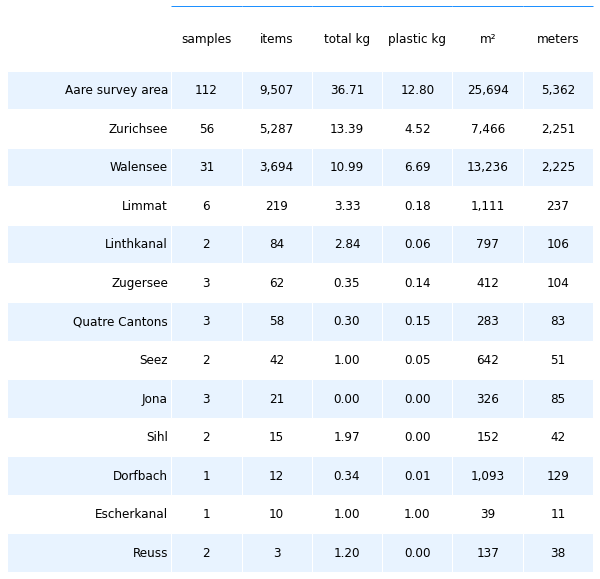

In [6]:
a_color='dodgerblue'

dims_table[[x for x in dims_table.columns if x not in ['plastic kg', 'total kg']]] = dims_table[[x for x in dims_table.columns if x not in ['plastic kg', 'total kg']]].applymap(lambda x: '{:,}'.format(int(x)))
dims_table[['plastic kg', 'total kg']] = dims_table[['plastic kg', 'total kg']].applymap(lambda x: '{:.2f}'.format(x))

data = dims_table.reset_index()

fig, axs = plt.subplots(figsize=(len(data.columns)*1.5,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.28, *[.12]*6], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=False)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

## Land use profile of the surveys

The distribution of the number of surveys completed at the different land use rates. The land use is reported as the percent of total area attributed to each land use category within a 1500m  radius of the survey location. Streets are reported as the total number of kilometers of streets within the 1500m radius. Intersects is also an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location.

See the section *Land use features* for more details

In [7]:
# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,'% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods','population','water_name_slug','streets km', 'intersects', 'groupname','code']
lakes_s = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name_slug'].unique()

# assign each record to lakes or rivers
# note that water_name_slug is not the same as water_name
fd['w_t'] = 'r'
fd.loc[fd.water_name_slug.isin(lakes_s), 'w_t'] = 'l'
lakes_s = fd[fd.w_t == "l"].water_name_slug.unique()

# walensee landuse is approximated by comparing the land use profile from similar locations
# the classification for that part of switzerland is incomplete for the current estimates
# the previous one is 15 years old

# the land use profile of wychely - brienzersee was used for walenstadt-wyss (more prairie, buildings less woods)
# the land use profile of grand-clos - lac-leman was used for other locations on walensee (more woods, less buildings, less praire and agg)
luse_wstdt = dfBeaches.loc['wycheley'][['population','% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods']]
estimate_luse = dfBeaches.loc['grand-clos'][['population','% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods']]

# seperate out the locations that aren't walenstadt
wlsnsee_locs_not_wstdt = ['gasi-strand', 'untertenzen', 'mols-rocks', 'seeflechsen', 'seemuhlestrasse-strand', 'muhlehorn-dorf', 'murg-bad', 'flibach-river-right-bank']

for a_param in estimate_luse.index:
    fd.loc[fd.location.isin(wlsnsee_locs_not_wstdt), a_param] = estimate_luse[a_param]
    fd.loc['walensee_walenstadt_wysse', a_param] = luse_wstdt[a_param]
    
dfdt = fd.groupby(use_these_cols[:-2], as_index=False).agg(agg_pcs_quantity)

# figure caption
site_string = F"""
*{level_names[0]}: land use attributes of the survey locations. Distribution of samples with respect to land use.* 
"""
md(site_string)


*Linth survey area: land use attributes of the survey locations. Distribution of samples with respect to land use.* 


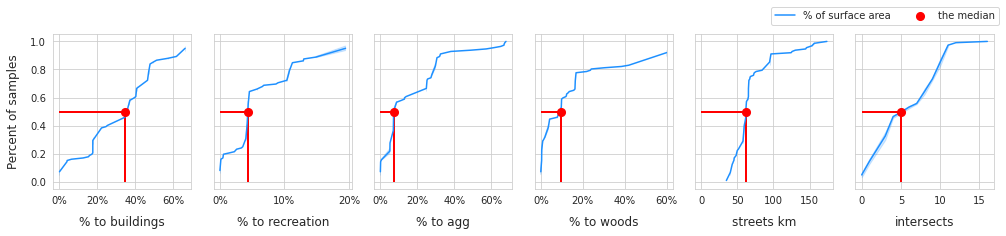

In [8]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,3), sharey=True)

data = dfdt.copy()

for i, n in enumerate(luse_exp):
    ax=axs[i]
    # get the empirical distribution of the independent variable
    the_data = ECDF(data[n].values)
    x, y = the_data.x, the_data.y   
    
    # plot that
    sns.lineplot(x=x, y=y, ax=ax, color='dodgerblue', label="% of surface area")
    
    # get the median from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color='red', linewidth=2)
    
    # save the handels and labels but remove them from the ax    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    
    # format the % of total on the xaxis:
    if i <= 3:
        if i == 0:            
            ax.set_ylabel("Percent of samples", **ck.xlab_k)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, '%'))        
    else:
        pass
    ax.set_xlabel(n, **ck.xlab_k)

plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(1,1.1), loc='upper right', ncol=2)
plt.show()

### Choosing survey sites

The survey locations were chosen based on the following criteria:

1. Data from previous surveys (SLR, MCBP)
2. Year round safe access
3. Within 30 minutes walking distance from nearest public transport

In [9]:
site_string = F"""The survey locations represent the land use conditions accesible to approximateley {pop_string} people and a
variety of land use conditions within the survey area. For more information see the document *Survey site selection and criteria*.
"""
md(site_string)

The survey locations represent the land use conditions accesible to approximateley 612,111 people and a
variety of land use conditions within the survey area. For more information see the document *Survey site selection and criteria*.


## Survey results all objects

Survey totals by date and monthly or quarterly median survey result for all survyes. The empirical cumulative distribution of survey results for all lakes in the survey area.

In [10]:
# assign a month column to the survey totals
fd_dt['month'] = fd_dt.date.dt.month

# make a df of survey totals with date as index
# only the surveys from all other survey areas
dts_date = a_dt[~a_dt.water_name_slug.isin(fd.water_name_slug.unique())].set_index('date')

# the surveys from the river bassin
fd_dindex = fd_dt.set_index('date')

# samples were taken quarterly in ticino
if bassin_name == 'ticino':
    monthly_plot = fd_dindex[unit_label].resample('Q').median()
else:
    monthly_plot = fd_dindex[unit_label].resample('M').median()

# scale the chart as needed to accomodate for extreme values
scale_back = 98

# the results gets applied to the y_limit function in the cahrt
the_90th = np.percentile(fd_dt[unit_label], scale_back)
not_included = F"Values greater than {round(the_90th, 1)}{unit_label} {scale_back}% not shown."

# figure caption
chart_notes = F"""
*__Left:__ {level_names[0]}, {start_date[:7]} through {end_date[:7]}, n={fd_n_samps}. {not_included}*
"""
md(chart_notes )


*__Left:__ Linth survey area, 2020-03 through 2021-05, n=112. Values greater than 422.2p/50m 98% not shown.*


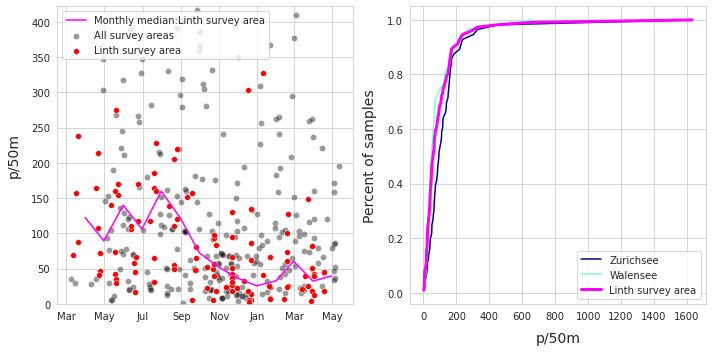

In [11]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

fig, axs = plt.subplots(1,2, figsize=(10,5))

# check the river bassin, ticinon is qrtrly samples for now:
if bassin_name == 'ticino':
    rate = "Quarterly"
else:
    rate = "Monthly"

line_label = F"{rate} median:{level_names[0]}"

ax = axs[0]
sns.scatterplot(data=dts_date, x='date', y=unit_label, color='black', alpha=0.4, label=level_names[1], ax=ax)
sns.scatterplot(data=fd_dt, x='date', y=unit_label, color='red', s=34, ec='white',label=level_names[0], ax=ax)

sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color='magenta', label=line_label, ax=ax)

ax.set_ylim(0,the_90th )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)


axtwo = axs[1]
lake_dts = fd[fd.water_name_slug.isin(lakes_of_interest)].groupby(['water_name_slug', 'loc_date'], as_index=False)[unit_label].sum()

for i, a_name in enumerate(lakes_of_interest):
    label=wname_wname.loc[a_name][0]
    
    a_ecdf = ECDF(lake_dts[lake_dts.water_name_slug == a_name][unit_label].values)
    
    sns.lineplot(x=a_ecdf.x, y=a_ecdf.y, color=lake_colors[i], ax=axtwo, label=label)

r_bassin = ECDF(fd_dt[unit_label].values)
sns.lineplot(x=r_bassin.x, y=r_bassin.y, color='magenta', label=level_names[0], linewidth=3, ax=axtwo)
axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Percent of samples", **ck.xlab_k14)

plt.tight_layout()
plt.show()
plt.close()

In [12]:
lakes_ecdf = F"""
*__Right:__ {level_names[0]} empirical cumulative distribution of survey results of all lakes*
"""
md(lakes_ecdf)


*__Right:__ Linth survey area empirical cumulative distribution of survey results of all lakes*


### Summary data and material types

In [13]:
# figure caption
summary_of_survey_totals = F"""
*__Left:__ {level_names[0]} summary of survey totals*
"""
md(summary_of_survey_totals)


*__Left:__ Linth survey area summary of survey totals*


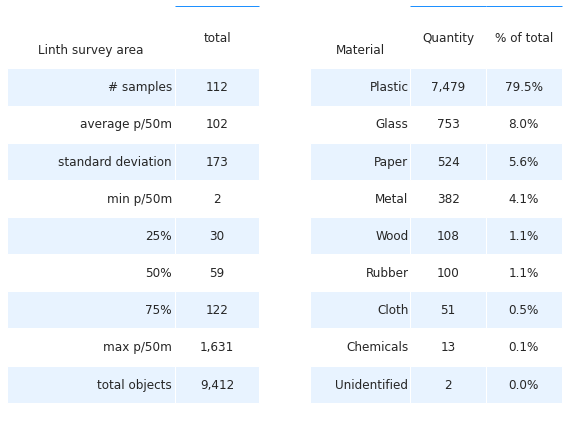

In [14]:
# the labels for the summary table:
change_names = {'count':'# samples', 
                'mean':F"average {unit_label}",
                'std':'standard deviation', 
                'min p/50m':'min', '25%':'25%',
                '50%':'50%', '75%':'75%',
                'max':F"max {unit_label}", 'min':F"min {unit_label}",
                'total objects':'total objects',
                '# locations':'# locations',
                'survey year':'survey year'
               }

# convenience function to change the index names in a series
def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

# select data
data = fd_dt

# get the basic statistics from pd.describe
desc_2020 = data[unit_label].describe().round(2)

# add project totals
desc_2020['total objects'] = data.quantity.sum()
desc_2020['# locations'] = fd.location.nunique()

# change the names
combined_summary = pd.Series(anew_dict(desc_2020))

# format the output for printing:
not_formatted = combined_summary[-1]
combined_summary = [(x, "{:,}".format(int(combined_summary[x]))) for x in combined_summary.index[:-1]]
combined_summary.append((desc_2020.index[-1], int(not_formatted) ))

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [level_names[0], 'total']

axone = axs[0]
ut.hide_spines_ticks_grids(axone)

a_table = axone.table(cellText=combined_summary[:-1],  colLabels=a_col, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],a_col, s_et_bottom_row=False)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
ut.hide_spines_ticks_grids(axtwo)
data = fd_mat_t.copy()

# column names for display
cols_to_use = {'material':'Material','quantity':'Quantity', '% of total':'% of total'}

# sort data before formatting
data.sort_values(by='quantity', inplace=True, ascending=False)

# format results
data['% of total'] =(data['% of total']*100).round(1)
data['quantity']=data.quantity.map(lambda x: '{:,}'.format(x))
data['% of total']=data['% of total'].map(lambda x:F"{x}%")

a_table = axtwo.table(cellText=data.values,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,data,list(cols_to_use.values()), s_et_bottom_row=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

In [15]:
# figure caption
material_type = F"""
*__Right:__ {level_names[0]} material type and percent of total*
"""
md(material_type)


*__Right:__ Linth survey area material type and percent of total*


## The most common objects

The most common objects are **the ten most abundant by quantity found** AND/OR **any object that was indentified in at least 50% of all the surveys**. 

In [16]:
# the top ten by quantity
most_abundant = fd_code_t.sort_values(by='quantity', ascending=False)[:10]

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/fd_code_t.quantity.sum()

# figure caption
rb_string = F"""
*{level_names[0]} most common objects: fail rate > {a_fail_rate}%  and/or top ten by quantity. 
Combined, the ten most abundant objects represent {int(m_common_percent_of_total*100)}% of all objects found, {unit_label}: median survey value.*
"""
md(rb_string)


*Linth survey area most common objects: fail rate > 50%  and/or top ten by quantity. 
Combined, the ten most abundant objects represent 66% of all objects found, p/50m: median survey value.*


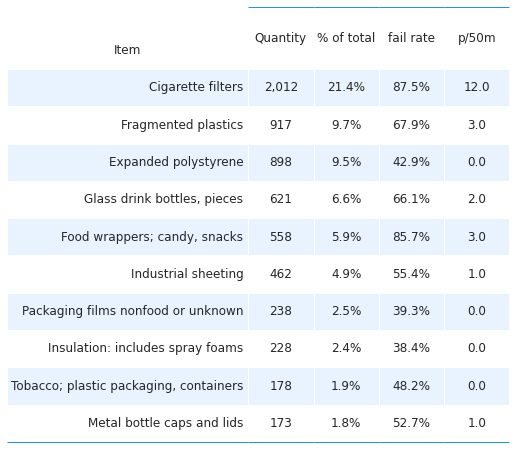

In [17]:
# format values for table
m_common['item'] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common['% of total'] = m_common["% of total"].map(lambda x: F"{x}%")
m_common['quantity'] = m_common.quantity.map(lambda x: '{:,}'.format(x))
m_common['fail rate'] = m_common['fail rate'].map(lambda x: F"{x}%")
m_common['p/50m'] = m_common['p/50m'].map(lambda x: F"{np.ceil(x)}")

# final table data
cols_to_use = {'item':'Item','quantity':'Quantity', '% of total':'% of total', 'fail rate':'fail rate', 'p/50m':'p/50m'}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(9,len(m_common)*.8))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.48, .13,.13,.13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,m_common,list(cols_to_use.values()), a_color)

plt.show()
plt.tight_layout()
plt.close()

### Most common objects: results by water feature

In [18]:
rb_string = F"""
*{level_names[0]} most common objects: median {unit_label}*

*All water features and samples*
"""
md(rb_string)


*Linth survey area most common objects: median p/50m*

*All water features and samples*


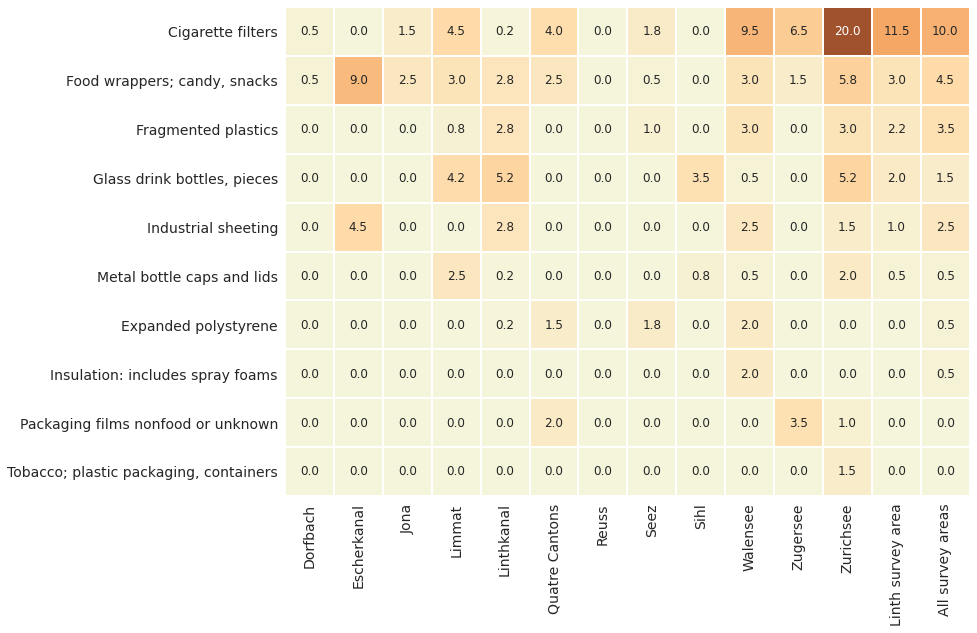

In [19]:
# aggregated survey totals for the most common codes for all the water features 
m_common_st = fd[(fd.code.isin(m_common.index))].groupby(['water_name_slug', 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby(['water_name_slug', 'code'], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft['f_name'] = m_common_ft.water_name_slug.map(lambda x: wname_wname.loc[x][0])

# map the desctiption to the code
m_common_ft['item'] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[['item', unit_label, 'f_name']].pivot(columns='f_name', index='item')

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the river bassin
fd_mc = fd[fd.code.isin(m_common.index)].groupby(['water_name_slug', 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
fd_mc = fd_mc.groupby('code', as_index=False)[unit_label].median()

# set the item, index and column name for the aggregated survey area results
fd_mc['item'] = fd_mc.code.map(lambda x: code_description_map.loc[x])
fd_mc.set_index('item', inplace=True)

# the column of values for the survye area
fd_mc[level_names[0]] = fd_mc[unit_label]

# repeat for all the survey areas
a_s_a = a_data[a_data.code.isin(m_common.index)].groupby(['water_name_slug', 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
a_s_a = a_s_a.groupby('code', as_index=False)[unit_label].median()
a_s_a['item'] = a_s_a.code.map(lambda x: code_description_map.loc[x])
a_s_a.set_index('item', inplace=True)
a_s_a[level_names[1]] = a_s_a[unit_label]

ad_t_ten = pd.concat([m_c_p, fd_mc[level_names[0]], a_s_a[level_names[1]],], axis=1).sort_values(by=level_names[0], ascending=False)

# chart that
fig, ax  = plt.subplots(figsize=(len(ad_t_ten.columns)*.9,len(ad_t_ten)*.9))
axone = ax

sns.heatmap(ad_t_ten, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both')

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

### Most common objects: monthly average

In [20]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(['loc_date','date','code', 'groupname'], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index('date', inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(['code','groupname'], as_index=False).quantity.sum().sort_values(by='groupname')['code'].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*{level_names[0]}, monthly average survey result {unit_label}*

*Detail of the most common objects*
"""
md(monthly_mc)


*Linth survey area, monthly average survey result p/50m*

*Detail of the most common objects*


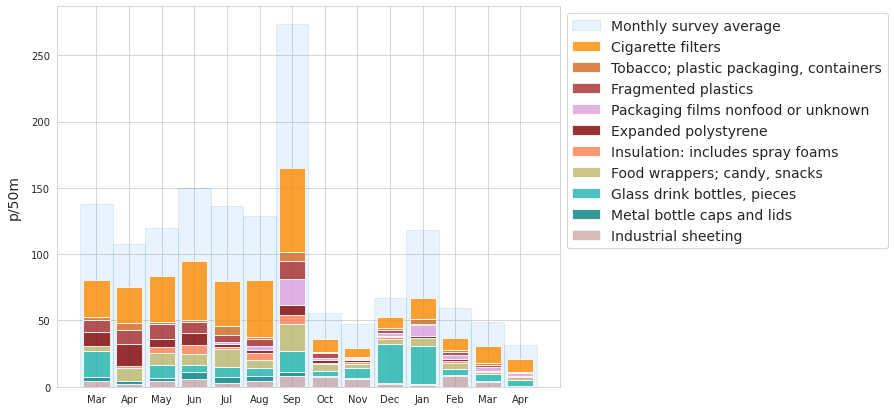

In [21]:
# color palette for the most common objects
colors_palette = {
    'G156':'dimgray', 'G178': 'teal',
    'G177': 'darkslategray',
    'G200': 'lightseagreen',
    'G27':'darkorange',
    'G30':'darkkhaki',
    'G67':'rosybrown',
    'G89': 'salmon',
    'G95':'magenta',
    'G82': 'maroon',
    'G79':'brown',
    'G208': 'turquoise',
    'G124':'indigo',
    'G25': 'chocolate',
    'G31': 'goldenrod',
    'G21':'tan',
    'Gfrags':'brown',
    'Gfoam':'maroon',
    'G117':'cornsilk',
    'G941':'plum',
    'G74':'coral',
    'G112': 'yellow',
    'G24':'navajowhite',
    'G23':'peru',
    'G100':'pink',
    'G32':'khaki',
    'G33':'lemonchiffon',
    'G35':'blue'
    
}
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(9,7))

# define a bottom
bottom = [0]*len(mgr['G27'])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(['loc_date', 'date'], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index('date', inplace=True)
m_fd = monthly_fd[unit_label].resample('M').mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color='dodgerblue', alpha=0.1, linewidth=1, edgecolor='teal', width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

## Survey results and land use

Land use is a method to differentiate survey sites in other ways besides the amount of trash collected. The land use mix is a unique representation of the type and amplititude of econmic activity around the survey location. The key indicators from the survey results are compared against the land use rates for a radius of 1500m from the survey location.


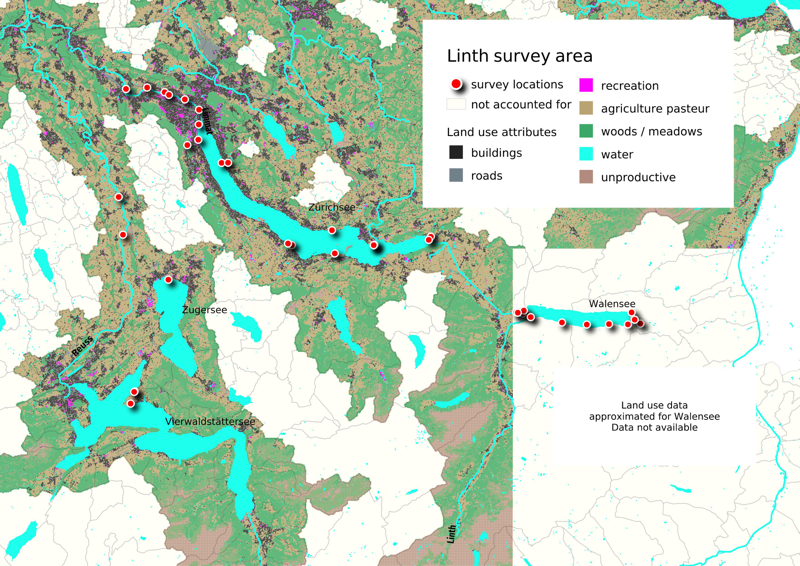

In [22]:
output = io.BytesIO()
land_use_map.thumbnail((800, 1200))
land_use_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

Ranked correlation is a test to determine if there is a statistically significant relationship between land use and beach-litter-survey results.

The method used is the Spearman's $\rho$ or *Spearmans ranked correlation coefficient*. The test results are evaluated at p<0.05 for **all valid lake samples** in the survey area. 

1. Red/rose is a postitive association
2. Yellow is a negative association
3. White means that p>0.05, there is no statisitical basis to assume an association

An association is a relationship between the survey results and the land use attributes that is unlikely due to chance. The magnitude of the relationship is not defined and it is not linear.

### Results of Spearmans $\rho$

In [23]:
corr_data = fd[(fd.code.isin(m_common.index))&(fd.water_name_slug.isin(lakes_s))].copy()

alert_less_than_100 = len(corr_data.loc_date.unique()) <= 100

if alert_less_than_100:
    warning = F"""**There are less than 100 samples, proceed with caution. Beach litter surveys have alot of variance**"""
    association = F"""*{level_names[0]} ranked correlation of the most common objects with respect to land use profile.
For all valid lake samples n={len(corr_data.loc_date.unique())}, for each of the most common codes.*

*Key: &nbsp;if p>0.05 = white, &nbsp;if p < 0.05 and $\\rho$ > 0 = red, &nbsp;if p < 0.05 and $\\rho$ < 0 = yellow*

*{warning}*
"""
else:
    association = F"""*{level_names[0]} ranked correlation of the most common objects with respect to land use profile.
For all valid lake samples n={len(corr_data.loc_date.unique())}, for each of the most common codes.*

*Key: &nbsp;if p>0.05 = white, &nbsp;if p < 0.05 and $\\rho$ > 0 = red, &nbsp;if p < 0.05 and $\\rho$ < 0 = yellow*
"""


md(association)

*Linth survey area ranked correlation of the most common objects with respect to land use profile.
For all valid lake samples n=93, for each of the most common codes.*

*Key: &nbsp;if p>0.05 = white, &nbsp;if p < 0.05 and $\rho$ > 0 = red, &nbsp;if p < 0.05 and $\rho$ < 0 = yellow*

***There are less than 100 samples, proceed with caution. Beach litter surveys have alot of variance***


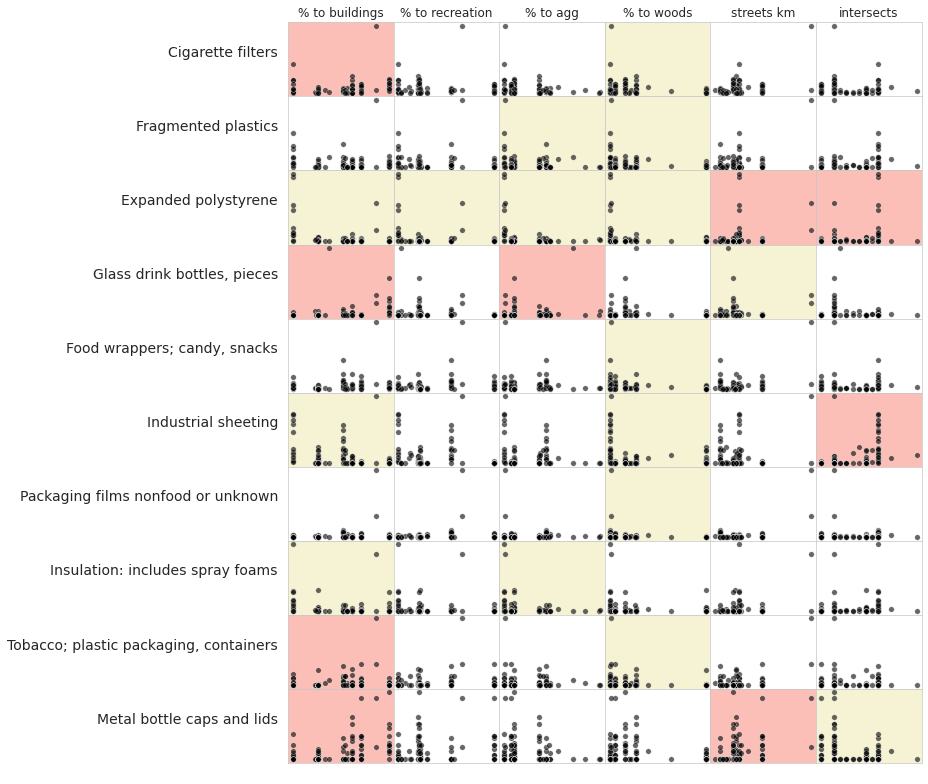

In [24]:
# the data to be tested
corr_data = fd[(fd.code.isin(m_common.index))&(fd.water_name_slug.isin(lakes_s))].copy()

# chart the results of test for association
fig, axs = plt.subplots(len(m_common.index),len(luse_exp), figsize=(len(luse_exp)+7,len(m_common.index)+1), sharey='row')

# the test is conducted on the survey results for each code
for i,code in enumerate(m_common.index):
    # slice the data
    data = corr_data[corr_data.code == code]
    
    # run the test on for each land use feature
    for j, n in enumerate(luse_exp):       
        # assign ax and set some parameters
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis='both', which='both',bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
        
        # check the axis and set titles and labels       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha='right', **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        # run test
        _, corr, a_p = make_plot_with_spearmans(data, ax, n)
        
        # if siginficant set adjust color to direction
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor('salmon')
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor('palegoldenrod')
                ax.patch.set_alpha(0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(F"{project_directory}/test_one.jpg", dpi=300)
plt.show()

### Interpreting Spearmans $\rho$

A positive association means that the land use attribute or feature had increased survey results when compared to other locations. This may be due to a covariance of attributes, either way **a positive association is a signal that the survey locations are near a zone of accumulation or a source**. This signal should be assessed along with the other key indicators of survey locations that have similar land use profiles. In general locations that fit the criteria could be considered as both a source and an area of accumulation for any objects that are positively associated.

A negative association means that the land use feature or attribute does not facilitate the accumulation of the object. This result is common for aggricultural areas and woods on the national level. **A negative association is a signal that the locations are not a zone of accumulation for the object**.

No or few association means that the land use features had no effect on the accumulation of that object. The survey results of the most common objects with no or few associations fall into two charateristics: 

1. Ubiquitous: high fail rate, high pieces per meter. Found at consistent rates through out the survey area indifferent of land use
2. Transient: low fail rate, high quantity, high pieces per meter, few associations. Found occasionaly in large quantities at specific locations

## Utility of the objects found

The utility type is based on the utilisation of the object prior to it being discarded. Objects that are found are placed into to one of the 260 categories. Those categories are grouped according to utilisation.

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastic items and pre-production plastic resins
*  **infrastructure**: items related to construction and maintenance of all infratructure items 
*  **food and drink**: primarily single use plastic items related to consuming food and drinks outdoors  
*  **agriculture**: primarily industrial sheeting includes mulch films
*  **tobacco**: primarily cigarette ends includes all smoking related material 
*  **recreation**: includes fishing, hunting, boating and beach related objects, excludes food, drink and tobacco items   
*  **packaging non food and drink**: packaging or wrapping material not identified as food, drink nor tobacco related  
*  **plastic fragments**: foam and plastic fragments of indeterminate origin and use 
*  **personal items**: accessories, hygiene and clothing related 

See the annex for the complete list of objects identified, includes category and group classification.

In [25]:
cg_poft = F"""
<br></br>
*{level_names[0]} utility of objects found: % of total by water feature. Fragmented objects with no clear identification remain classified by size.
"""
md(cg_poft)


<br></br>
*Linth survey area utility of objects found: % of total by water feature. Fragmented objects with no clear identification remain classified by size.


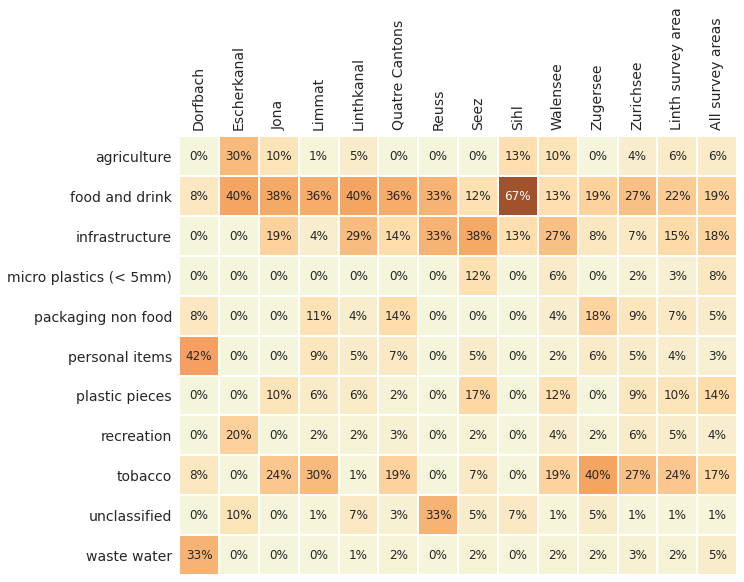

In [26]:
# code groups aggregated by survey for each water feature in the survey area
cg_t = fd.groupby(['water_name_slug','loc_date', 'groupname'], as_index=False).agg(agg_pcs_quantity)

# get the fail rates for each group per survey
cg_t['fail']=False
cg_t['fail'] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each water feature
cg_t = cg_t.groupby(['water_name_slug', 'groupname'], as_index=False).agg({unit_label:'median', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'})

# quantity per water feature
cg_tq = cg_t.groupby('water_name_slug').quantity.sum()

# assign the water feature total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t.water_name_slug == a_feature, 'f_total'] = cg_tq.loc[a_feature]

# get the percent of total for each group for each water feature
cg_t['pt'] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns='water_name_slug', index='groupname', values='pt')

# add a column for the survey area totals and the national totals:
# the aggregated totals for the survey area

# the median value is always calculated from the survey result:
sa_cg = fd.groupby(['water_name_slug', 'loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)

# aggregate all data
fd_cg = sa_cg.groupby('groupname', as_index=False).agg({unit_label:'median', 'quantity':'sum'})

# add percent of total column
fd_cg['pt'] = (fd_cg.quantity/fd_cg.quantity.sum()).round(2)

# set the index
fd_cg.set_index('groupname', inplace=True)

# name survey area column
fd_cg[level_names[0]] = fd_cg['pt']

# repeat for all data
a_s_a = a_data.groupby(['water_name_slug', 'loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)
a_s_a = a_s_a.groupby('groupname', as_index=False).agg({unit_label:'median', 'quantity':'sum'})
a_s_a['pt'] = (a_s_a.quantity/a_s_a.quantity.sum()).round(2)
a_s_a.set_index('groupname', inplace=True)
a_s_a[level_names[1]] = a_s_a['pt']

data = pd.concat([data_table, fd_cg[level_names[0]], a_s_a[level_names[1]]], axis=1)
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)
# data = data.applymap(lambda x: F"{x}%")

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt='.0%', linewidth=.1, square=True, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both', labeltop=True, labelbottom=False)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

In [27]:
# median p/50m solve cg_t for unit_label
data_table = cg_t.pivot(columns='water_name_slug', index='groupname', values=unit_label)

# survey area median
fd_cg[level_names[0]] = fd_cg[unit_label]

# all survey area median
a_s_a[level_names[1]] = a_s_a[unit_label]

# merge with data_table
data = pd.concat([data_table, fd_cg[level_names[0]], a_s_a[level_names[1]]], axis=1)

# format for display
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)


cg_medpcm = F"""
<br></br>
{level_names[0]} utility of objects found: median {unit_label}. Fragmented objects with no clear identification remain classified by size.
"""
md(cg_medpcm)


<br></br>
Linth survey area utility of objects found: median p/50m. Fragmented objects with no clear identification remain classified by size.


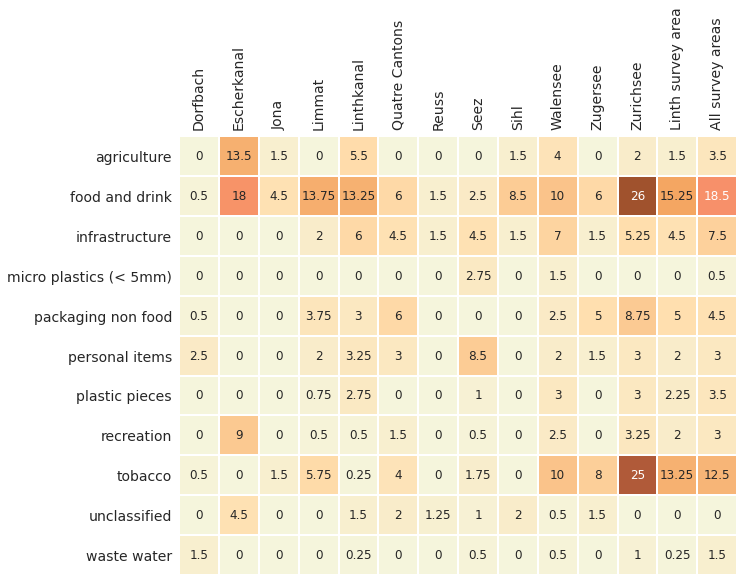

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt='g', cbar=False, linewidth=.1, square=True, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both', labeltop=True, labelbottom=False)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Rivers 

In [29]:
rivers = fd[fd.w_t == 'r'].copy()
r_smps = rivers.groupby(['loc_date', 'date', 'location', 'water_name_slug'], as_index=False).agg(agg_pcs_quantity)
l_smps = fd[fd.w_t == 'l'].groupby(['loc_date','date','location', 'water_name_slug'], as_index=False).agg(agg_pcs_quantity)

chart_notes = F"""
*__Left:__ {level_names[0]} rivers, {start_date[:7]} through {end_date[:7]}, n={len(r_smps)}. {not_included}*

*__Right:__ Summary data.*
"""
md(chart_notes )


*__Left:__ Linth survey area rivers, 2020-03 through 2021-05, n=19. Values greater than 422.2p/50m 98% not shown.*

*__Right:__ Summary data.*


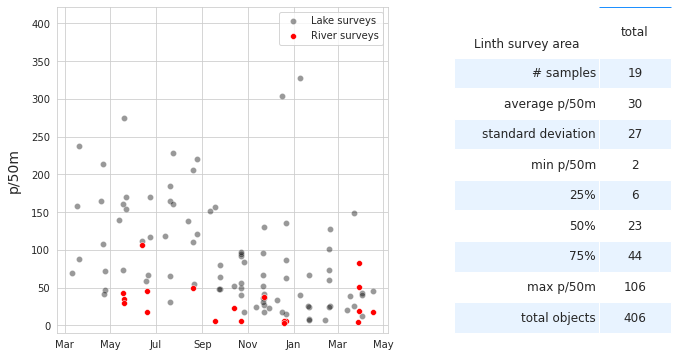

In [30]:
# select data
data = r_smps

# get the basic statistics from pd.describe
desc_2020 = data[unit_label].describe().round(2)

# add project totals
desc_2020['total objects'] = data.quantity.sum()
desc_2020['# locations'] = fd.location.nunique()

# change the names
combined_summary = pd.Series(anew_dict(desc_2020))

# format the output for printing:
not_formatted = combined_summary[-1]
combined_summary = [(x, "{:,}".format(int(combined_summary[x]))) for x in combined_summary.index[:-1]]
combined_summary.append((desc_2020.index[-1], int(not_formatted) ))

# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

# make the charts
fig = plt.figure(figsize=(11,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{level_names[0]}"

sns.scatterplot(data=l_smps, x='date', y=unit_label, color='black', alpha=0.4, label="Lake surveys", ax=ax)
sns.scatterplot(data=r_smps, x='date', y=unit_label, color='red', s=34, ec='white',label="River surveys", ax=ax)

ax.set_ylim(-10,the_90th )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

a_col = [level_names[0], 'total']

axone = fig.add_subplot(aspec[:, 7:])
ut.hide_spines_ticks_grids(axone)

a_table = axone.table(cellText=combined_summary[:-1],  colLabels=a_col, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],a_col, s_et_bottom_row=False)

plt.show()

### Rivers most common objects

In [31]:
riv_mcommon = F"""
*{level_names[0]} rivers, most common objects*

*{unit_label}: median survey value*
"""
md(riv_mcommon)


*Linth survey area rivers, most common objects*

*p/50m: median survey value*


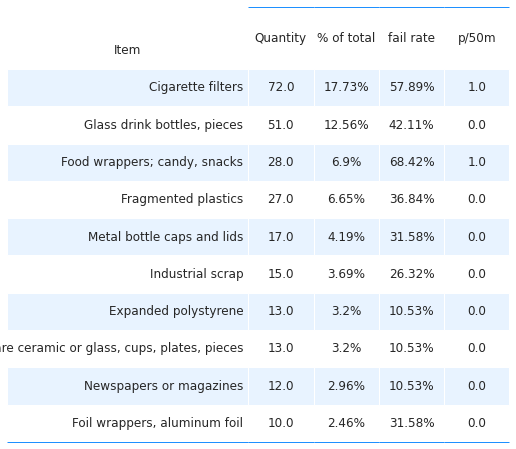

In [32]:
# the most common items rivers
r_codes = rivers.groupby('code').agg({'quantity':'sum', 'fail':'sum', unit_label:'median'})
r_codes['fail rate'] = (r_codes.fail/r_smps.loc_date.nunique()*100).round(2)

# top ten
r_byq = r_codes.sort_values(by='quantity', ascending=False)[:10].index

# most common
r_byfail = r_codes[r_codes['fail rate'] > 49.99].index
r_most_common = list(set(r_byq) | set(r_byfail))

# format for display
r_mc= r_codes.loc[r_most_common].copy()
r_mc['item'] = r_mc.index.map(lambda x: code_description_map.loc[x])
r_mc.sort_values(by='quantity', ascending=False, inplace=True)

r_mc['% of total']=((r_mc.quantity/r_codes.quantity.sum())*100).round(2)
r_mc['% of total'] = r_mc["% of total"].map(lambda x: F"{x}%")
r_mc['quantity'] = r_mc.quantity.map(lambda x: '{:,}'.format(x))
r_mc['fail rate'] = r_mc['fail rate'].map(lambda x: F"{x}%")
r_mc['p/50m'] = r_mc['p/50m'].map(lambda x: F"{np.ceil(x)}")
r_mc.rename(columns=cols_to_use, inplace=True)

data=r_mc[list(cols_to_use.values())]

fig, axs = plt.subplots(figsize=(9,len(data)*.8))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=list(cols_to_use.values()), colWidths=[.48, .13,.13,.13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,list(cols_to_use.values()), a_color)

plt.show()
plt.tight_layout()
plt.close()

<br></br>
## More information

For more information about the project visit [project home](https://www.plagespropres.ch/).

If you would like more information about this survey area please contact:

1. Swiss federal office for the environment - Municipal waste section
2. analyst@hammerdirt.ch
<br></br>

In [33]:
author = author
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*analyst@hammerdirt* pushed the run button on 2021-08-30.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>


## Annex

### fragmented foams and plastics by size group

These are the components of Gfoam and Gfrags, objects labled "Expanded foams" are grouped with Gfoam the rest are grouped under Gfrags.

In [34]:
frag_foams = F"""
*{level_names[0]} fragmented foams and plastics by size group. 

*median {unit_label}, number of pieces, percent of total*
"""
md(frag_foams)


*Linth survey area fragmented foams and plastics by size group. 

*median p/50m, number of pieces, percent of total*


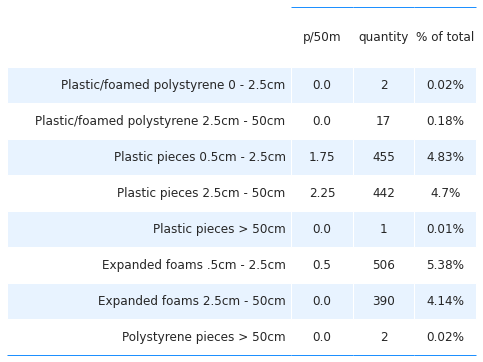

In [35]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(fd_locs))].groupby(['loc_date','code'], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby('code').agg({unit_label:'median', 'quantity':'sum'})

# add code description and format for printing
fd_frags_foams['item'] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams['% of total'] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams['% of total'] = fd_frags_foams['% of total'].map(lambda x: F"{x}%")
fd_frags_foams['quantity'] = fd_frags_foams['quantity'].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[['item',unit_label, 'quantity', '% of total']]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### IQAASL surveyors

Hammerdirt staff:

1. Shannon Erismann, field operations manager
2. Helen Kurukulasuriya, surveyor
3. Débora Carmo, surveyor
4. Roger Erismann, surveyor

Participating organizations:

1. Precious plastic leman

### Survey locations

In [36]:
# display the survey locations
pd.set_option('display.max_rows', None)
disp_columns = ['latitude', 'longitude', 'city', 'population', 'streets', '% to buildings']
disp_beaches = dfBeaches.loc[fd_locs][disp_columns]
disp_beaches

,latitude,longitude,city,population,streets,% to buildings
slug,,,,,,
limmat_dietikon_keiserp,47.407989,8.409540,Dietikon,27265,130217,0.393393
zugerseecholler_cham_blarerm,47.178216,8.480013,Zug,30542,64555,0.370690
vierwaldstattersee_weggis_schoberls_1,47.044532,8.418569,Weggis,4369,44328,0.157635
vierwaldstattersee_weggis_schoberls_2,47.043953,8.417308,Weggis,4369,43729,0.153061
vierwaldstattersee_weggis_schoberls_3,47.029957,8.410801,Weggis,4369,34747,0.221429
limmat_unterengstringen_oggierbuhrer,47.409400,8.446933,Unterengstringen,3881,125842,0.401773
limmat_zuerich_wagnerc,47.403496,8.477770,Zürich,415367,144548,0.463450
limmat_zurich_mortensena_meiera,47.400252,8.485411,Zürich,415367,153155,0.493431
sihl_zuerich_eggerskoehlingera,47.381898,8.538328,Zürich,415367,173894,0.615497


### Inventory of all items

In [37]:
pd.set_option('display.max_rows', None)
complete_inventory = fd_code_t[fd_code_t.quantity>0][['item', 'quantity', 'utility',  '% of total','fail rate']]
complete_inventory

,item,quantity,utility,% of total,fail rate
code,,,,,
G27,Cigarette filters,2012,tobacco,21.4,87.5
Gfrags,Fragmented plastics,917,plastic pieces,9.7,67.9
Gfoam,Expanded polystyrene,898,infrastructure,9.5,42.9
G200,"Glass drink bottles, pieces",621,food and drink,6.6,66.1
G30,"Food wrappers; candy, snacks",558,food and drink,5.9,85.7
G67,Industrial sheeting,462,agriculture,4.9,55.4
G941,Packaging films nonfood or unknown,238,packaging non food,2.5,39.3
G74,Insulation: includes spray foams,228,infrastructure,2.4,38.4
G25,"Tobacco; plastic packaging, containers",178,tobacco,1.9,48.2
